In [1]:
from collections import defaultdict
from datetime import datetime
import math
import sys

from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn

np.set_printoptions(threshold=sys.maxsize)

In [7]:
class TwoLayerNet(nn.Module):
    
    def __init__(self, d0, d1, d2, freeze=False):
        super(TwoLayerNet, self).__init__()
        
        layers = []
        
        lin_layer1 = nn.Linear(d0, d1)        
        torch.nn.init.normal_(lin_layer1.bias, mean=0., std=np.sqrt(2. / d0))        
        torch.nn.init.kaiming_normal_(lin_layer1.weight, nonlinearity='relu')
        if freeze:
            lin_layer1.bias.requires_grad = False
            lin_layer1.weight.requires_grad = False
        layers.append(lin_layer1)
        layers.append(nn.ReLU())
        
        lin_layer2 = nn.Linear(d1, d2, bias=False)
        torch.nn.init.normal_(lin_layer2.weight, mean=0., std=np.sqrt(1. / d1))
        # Freeze the weights in the last layer
        lin_layer2.weight.requires_grad = False
        layers.append(lin_layer2)
        
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    

class PolynomialRegression:

    def __init__(self, coef_lb, coef_ub, degree, d0):
        coef_arr = np.random.uniform(coef_lb, coef_ub, degree + 1)
        self.polynomial = np.polynomial.Polynomial(coef_arr)

    def __call__(self, x):
        return np.sum(self.polynomial(x), axis=-1)
    
    
def get_gaussian_data_np(d0, data_size, target_fn):
    x = np.random.normal(size=(data_size, d0))
    y = target_fn(x)
    return x, y
    
def get_gaussian_data(d0, data_size, target_fn):
    x = torch.tensor(np.random.normal(size=(data_size, d0)), dtype=torch.float)
    y = target_fn(x)
    return x, y

def get_A(model, x):
    return model.layers[0](x).detach().numpy() > 0

def get_A_rank(model, x):
    pattern = model.layers[0](x).detach().numpy() > 0
    return np.linalg.matrix_rank(pattern.astype(np.float64))  

# def contains_min(model, x, y, solver='linear regression'):    
#     N = x.size()[0]
#     d0 = x.size()[1]
#     d1 = len(model.layers[0].weight)
    
#     out1 = model.layers[0](x).detach().numpy()    
#     pattern = out1 > 0
    
#     w = model.layers[0].weight.detach().numpy().astype(np.float64)
#     b = model.layers[0].bias.detach().numpy().astype(np.float64)
#     v = model.layers[2].weight.detach().numpy().astype(np.float64)
#     x_np = x.detach().numpy().astype(np.float64)
#     y_np = y.detach().numpy().astype(np.float64)
#     print(f'w shape:{w.shape}')
    
#     # Check the number of dead neurons
#     false_dict = defaultdict(int)
#     for x_pattern in pattern:
#         for pi, p in enumerate(x_pattern):
#             if not p:
#                 false_dict[pi] += 1
#     dead_id = [ni for ni in false_dict if false_dict[ni] == N]
    
#     # Construct x for the linear regression problem
#     alive_v = np.asarray([[one_v for vi, one_v in enumerate(v[0]) if vi not in dead_id]])
#     alive_pattern = np.asarray([
#         [one_p for pi, one_p in enumerate(p_row) if pi not in dead_id] for p_row in pattern])
#     masked_v = np.concatenate([alive_v for _ in range(N)])
#     masked_v[np.invert(alive_pattern)] = 0.
     
#     masked_vx = alive_v * x_np
#     masked_vx[np.invert(alive_pattern)] = 0.
#     print(f'masked_vx shape: {masked_vx.shape}')
    
#     x_tilde = np.concatenate((masked_v, masked_vx), axis=1)
    
#     if solver == 'linear regression':
#         # Find the linear regression solution
#         beta_hat, _, _, _ = np.linalg.lstsq(x_tilde, y_np, rcond=None)
#     else:
#         ########################################################
#         ########################################################
#         ########################################################
#         # Find the quadratic problem solution
#         P = matrix(x_tilde.T @ x_tilde)
#         q = matrix(- x_tilde.T @ y_np)
#         param_num = P.size[1]  

#         G = np.zeros((N * param_num // 2, param_num))
#         for xi, x_pattern in enumerate(alive_pattern):
#             for pi, param_pattern in enumerate(x_pattern):
#                 # wx + b > 0
#                 if param_pattern:
#                     G[xi * param_num // 2 + pi][pi] = -1
#                     G[xi * param_num // 2 + pi][param_num // 2 + pi] = -x_np[xi]
#                 # wx + b <= 0
#                 else:
#                     G[xi * param_num // 2 + pi][pi] = 1
#                     G[xi * param_num // 2 + pi][param_num // 2 + pi] = x_np[xi]
#         G = matrix(G)
#         h = matrix(np.zeros(N * param_num // 2))

#         beta_hat = np.array(solvers.qp(P, q, G, h)['x'])
#         ########################################################
#         ########################################################
#         ########################################################    
        
#     # Check loss
#     pred_y = x_tilde @ beta_hat    
#     loss = np.mean((pred_y - y_np)**2)
#     zero_loss = np.isclose(loss, 0)
        
#     # Check activation pattern of the found solution
#     new_weight = w.copy()
#     new_bias = b.copy()
#     dead_count = 0
#     for ni in range(d1):
#         if ni not in dead_id:
#             new_bias[ni] = beta_hat[ni - dead_count][0]
#             new_weight[ni] = beta_hat[d1 - len(dead_id) + ni - dead_count]
#         else:
#             dead_count += 1
    
#     new_out = x_np @ new_weight.T + new_bias   
#     new_pattern = new_out > 0
    
#     same_pattern = tuple(pattern.reshape(-1)) == tuple(new_pattern.reshape(-1))
        
#     parameter_dim = len(model.layers[0].weight) * 2
#     eq_num = np.sum(np.isclose(np.min(np.abs(out1), axis=-1), 0))
#     region_dim = parameter_dim - eq_num
        
#     return loss, zero_loss, same_pattern, region_dim, new_pattern
def contains_min(model, x, y, solver='linear regression'):    
    N = x.size()[0]
    d0 = x.size()[1]
    d1 = len(model.layers[0].weight)
    
    out1 = model.layers[0](x).detach().numpy()    
    pattern = out1 > 0
#     print(f'pattern shape:{pattern.shape}')
    
    w = model.layers[0].weight.detach().numpy().astype(np.float64)
    b = model.layers[0].bias.detach().numpy().astype(np.float64)
    v = model.layers[2].weight.detach().numpy().astype(np.float64)
    x_np = x.detach().numpy().astype(np.float64)
    y_np = y.detach().numpy().astype(np.float64)
#     print(f'w shape:{w.shape}')
    
    # Check the number of dead neurons
    false_dict = defaultdict(int)
    for x_pattern in pattern:
        for pi, p in enumerate(x_pattern):
            if not p:
                false_dict[pi] += 1
    dead_id = [ni for ni in false_dict if false_dict[ni] == N]
    
    # Construct x for the linear regression problem
    # Construct the bias part
    alive_v = np.asarray([[one_v for vi, one_v in enumerate(v[0]) if vi not in dead_id]])
    alive_pattern = np.asarray([
        [one_p for pi, one_p in enumerate(p_row) if pi not in dead_id] for p_row in pattern])
#     print(f'alive pattern shape:{alive_pattern.shape}')
    masked_v = np.concatenate([alive_v for _ in range(N)])
    masked_v[np.invert(alive_pattern)] = 0.
#     print(f'masked_v shape: {masked_v.shape}')
    masked_v = np.expand_dims(masked_v, 1)
#     print(f'masked_v shape: {masked_v.shape}')
     
    # Construct the weight part
    w_alive_pattern = np.concatenate([np.expand_dims(alive_pattern, 1) for _ in range(d0)], 1)
#     print(f'alive pattern shape:{alive_pattern.shape}')
#     print(f'x_np: {x_np}')
#     print(f'x_np reshape: {x_np.T.reshape(-1)}')
#     masked_vx = alive_v * x_np.T.reshape(-1)
#     print(f'alive_v shape: {alive_v.shape}')
#     print(f'x_np shape: {x_np.shape}')
#     masked_vx = x_np.T.reshape((-1, 1)) @ alive_v#alive_v * x_np
    masked_vx = np.expand_dims(x_np, -1) @ alive_v#alive_v * x_np
#     print(f'masked_vx shape: {masked_vx.shape}')
    masked_vx[np.invert(w_alive_pattern)] = 0.
#     masked_vx[np.invert(alive_pattern)] = 0.
#     print(f'masked_vx shape: {masked_vx.shape}')
    
#     print(f'masked_v shape: {masked_v.shape}')
#     print(f'masked_vx shape: {masked_vx.shape}')
    x_tilde = np.concatenate((masked_v, masked_vx), axis=1)
#     print(f'x_tilde shape: {x_tilde.shape}')
#     print(f'x_tilde: {x_tilde[0]}')
    x_tilde = np.reshape(x_tilde, (N, -1))
#     print(f'x_tilde shape: {x_tilde.shape}')
#     print(f'x_tilde: {x_tilde[0]}')
    
    if solver == 'linear regression':
        # Find the linear regression solution
#         print(f'x_tilde shape: {x_tilde.shape}')
#         print(f'y_np shape: {y_np.shape}')
        beta_hat, _, _, _ = np.linalg.lstsq(x_tilde, y_np, rcond=None)
#         print(f'beta_hat shape: {beta_hat.shape}')
#         print(f'beta_hat: {beta_hat}')
    else:
        # Careful, might not work after the changed to higher dimensions
        ########################################################
        ########################################################
        ########################################################
        # Find the quadratic problem solution
        P = matrix(x_tilde.T @ x_tilde)
        q = matrix(- x_tilde.T @ y_np)
        param_num = P.size[1]  

        G = np.zeros((N * param_num // 2, param_num))
        for xi, x_pattern in enumerate(alive_pattern):
            for pi, param_pattern in enumerate(x_pattern):
                # wx + b > 0
                if param_pattern:
                    G[xi * param_num // 2 + pi][pi] = -1
                    G[xi * param_num // 2 + pi][param_num // 2 + pi] = -x_np[xi]
                # wx + b <= 0
                else:
                    G[xi * param_num // 2 + pi][pi] = 1
                    G[xi * param_num // 2 + pi][param_num // 2 + pi] = x_np[xi]
        G = matrix(G)
        h = matrix(np.zeros(N * param_num // 2))

        beta_hat = np.array(solvers.qp(P, q, G, h)['x'])
        ########################################################
        ########################################################
        ########################################################    
        
    # Check loss
    pred_y = x_tilde @ beta_hat    
    loss = np.mean((pred_y - y_np)**2)
    print(f'loss:{loss}')
    zero_loss = np.isclose(loss, 0)
        
    # Check activation pattern of the found solution
    new_weight = w.copy()
    new_bias = b.copy()
    dead_count = 0
    for ni in range(d1):
        if ni not in dead_id:
            new_bias[ni] = beta_hat[ni - dead_count]#[0]
            for wi in range(d0):
                new_weight[ni][wi] = beta_hat[(1 + wi) * (d1 - len(dead_id)) + ni - dead_count]
#             new_weight[ni][0] = beta_hat[d1 - len(dead_id) + ni - dead_count]
#             new_weight[ni][1] = beta_hat[2 * (d1 - len(dead_id)) + ni - dead_count]
        else:
            dead_count += 1
            
#     print(f'new_bias: {new_bias}')
#     print(f'new_weight: {new_weight}')
    
    new_out = x_np @ new_weight.T + new_bias   
    new_pattern = new_out > 0
    
    same_pattern = tuple(pattern.reshape(-1)) == tuple(new_pattern.reshape(-1))
        
    parameter_dim = len(model.layers[0].weight) * 2
    eq_num = np.sum(np.isclose(np.min(np.abs(out1), axis=-1), 0))
    region_dim = parameter_dim - eq_num
        
    return loss, zero_loss, same_pattern, region_dim, new_pattern

In [17]:
D0 = 1
# DATA = 'polynomial regression' # 'teacher-student'
DATA = 'teacher-student'
LINEAR_REGRESSION = False
RUNS_NUM = 10

d1_arr = [10 + 10 * (i) for i in range(10)]
data_size_arr = [10 + 10 * (i) for i in range(10)]

total_zero_loss = []
total_same_pattern = []
total_region_dim = []
total_A_rank = []

for d1 in d1_arr:
    print(f'!!! d1: {d1}')
    d1_zero_loss = []
    d1_same_pattern = []
    d1_region_dim = []
    d1_A_rank = []
    for data_size in data_size_arr:
        print(f'!!! data_size: {data_size}')
        
        if DATA == 'polynomial regression':
            x, y = get_gaussian_data_np(
                d0=D0,
                data_size=data_size,
                target_fn=PolynomialRegression(coef_lb=-1., coef_ub=1., degree=2, d0=D0)
            )
            x = torch.tensor(x, dtype=torch.float)
            y = torch.tensor(y, dtype=torch.float)
#             print(f'y size: {y.size()}')
        elif DATA == 'teacher-student':
            teacher_net = TwoLayerNet(d0=D0, d1=d1, d2=1, freeze=True)
            teacher_net.train(False)
            x, y = get_gaussian_data(d0=D0, data_size=data_size, target_fn=teacher_net)
        else:
            raise Exception(f'Wrong data name \"{DATA}\"')        
        
        original_pattern_arr = []
        same_pattern_arr = np.asarray([False for _ in range(RUNS_NUM)])
        region_dim_arr = np.zeros(RUNS_NUM)
        zero_loss_arr = np.asarray([False for _ in range(RUNS_NUM)])
        lr_pattern_arr = []
        A_rank_arr = []

        run_id = 0
        while len(original_pattern_arr) < RUNS_NUM:
            if (run_id + 1) % 100 == 0:
                print(f'=== Run {run_id + 1}/{RUNS_NUM} ===')
            model = TwoLayerNet(d0=D0, d1=d1, d2=1) 
            pattern_hash = hash(tuple(get_A(model, x).reshape(-1)))
            if pattern_hash not in original_pattern_arr:
                original_pattern_arr.append(pattern_hash)
                (_, zero_loss_arr[run_id], same_pattern_arr[run_id],
                 region_dim_arr[run_id], lr_pattern) = contains_min(model, x, y, LINEAR_REGRESSION)
                lr_pattern_arr.append(hash(tuple(lr_pattern.reshape(-1))))
                A_rank_arr.append(get_A_rank(model, x) / min(d1 + d1 * D0, data_size) * 100)
                run_id +=1

        print(f'Number of global minima: {np.sum(zero_loss_arr)}/{RUNS_NUM}')
        print(f'Number of same patterns: {np.sum(same_pattern_arr)}/{RUNS_NUM}')
        print(f'Unique lr patterns: {np.unique(lr_pattern_arr).shape[0]}/{RUNS_NUM}')
        print(f'Average region dimension: {np.mean(region_dim_arr)}')
        print()
        
        d1_zero_loss.append(np.mean(zero_loss_arr) * 100)
        d1_same_pattern.append(np.mean(same_pattern_arr) * 100)
        d1_region_dim.append(np.mean(region_dim_arr))
        d1_A_rank.append(np.mean(A_rank_arr))
        
    total_zero_loss.append(d1_zero_loss)
    total_same_pattern.append(d1_same_pattern)
    total_region_dim.append(d1_region_dim)
    total_A_rank.append(d1_A_rank)
    
total_zero_loss = np.asarray(total_zero_loss)
print(f'total_zero_loss:\n{total_zero_loss.shape}')
print(f'total_zero_loss:\n{total_zero_loss}')
print(f'total_same_pattern:\n{total_same_pattern}')
print(f'total_region_dim:\n{total_region_dim}')
print(f'total_A_rank:\n{total_A_rank}')

!!! d1: 10
!!! data_size: 10
loss:0.001422720285939974
loss:4.905342971597159e-07
loss:5.379377813491397e-07
loss:0.029264405430922326
loss:5.293097868580822e-07
loss:0.3140358497272404
loss:3.624819473531103e-06
loss:9.472455205901863e-05
loss:3.537018910997139e-06
loss:3.566728019196018e-06
Number of global minima: 0/10
Number of same patterns: 10/10
Unique lr patterns: 10/10
Average region dimension: 20.0

!!! data_size: 20
loss:0.001202768595387505
loss:1.1539940420389986e-05
loss:0.00036612854279171556
loss:0.008642892476276162
loss:7.543963105163518e-06
loss:0.00038309178044827654
loss:0.1038441024357029
loss:1.2391386815312576e-05
loss:0.006652519117628158
loss:4.141307136460859e-06
Number of global minima: 0/10
Number of same patterns: 10/10
Unique lr patterns: 10/10
Average region dimension: 20.0

!!! data_size: 30
loss:0.00022357365972709554
loss:2.9137291730457284
loss:0.0003136237823654714
loss:0.02622534528994934
loss:0.007894717461514152
loss:0.00018676498941686283
loss:0

loss:6.335370293080832e-09
loss:6.188400529357157e-07
loss:9.544722477048906e-06
loss:7.567924713818228e-07
loss:7.138702309973632e-07
loss:2.950287469961009e-06
Number of global minima: 2/10
Number of same patterns: 10/10
Unique lr patterns: 10/10
Average region dimension: 60.0

!!! data_size: 20
loss:3.3909947257892504e-05
loss:0.007587347213724423
loss:0.00013558874488582982
loss:4.442959259695342e-05
loss:0.0008396515331196945
loss:8.761486086901849e-06
loss:0.000405540193628168
loss:0.001025486426812084
loss:6.696478904436003e-05
loss:0.0010256055959053485
Number of global minima: 0/10
Number of same patterns: 10/10
Unique lr patterns: 10/10
Average region dimension: 60.0

!!! data_size: 30
loss:3.870782696071067e-05
loss:6.121380257627922e-05
loss:0.000109711179445329
loss:7.584417173923126e-05
loss:0.0013849220011944749
loss:7.91047607183883e-05
loss:0.00024472877293688365
loss:0.00040351529721355717
loss:0.00021812756735197064
loss:0.00028234906132814524
Number of global minima

loss:4.656494569308724e-05
loss:7.163686682637416e-06
loss:7.31600188425241e-09
loss:1.1951103228303337e-08
loss:6.631105974887514e-05
loss:4.2286052433968796e-05
Number of global minima: 1/10
Number of same patterns: 10/10
Unique lr patterns: 10/10
Average region dimension: 100.0

!!! data_size: 20
loss:0.000396510259124112
loss:1.5411096826176447e-06
loss:5.154085944881972e-08
loss:1.8984058622800864e-07
loss:1.5974071141313868e-06
loss:1.6870518634526377e-09
loss:0.0001320547749671194
loss:1.6384830266573189e-06
loss:1.026828950167719e-05
loss:0.00012944082421366556
Number of global minima: 1/10
Number of same patterns: 10/10
Unique lr patterns: 10/10
Average region dimension: 100.0

!!! data_size: 30
loss:2.5841222543404597e-09
loss:2.0473969329788672e-05
loss:0.0005092496705397292
loss:6.868681168863698e-05
loss:8.889571869718874e-06
loss:1.3762746117119915e-05
loss:1.2099369946099146e-05
loss:8.761882670038194e-06
loss:0.00026583342402811746
loss:1.7629089760083467e-05
Number of 

loss:1.5942952494436288e-06
loss:1.8037929672533983e-09
loss:1.3724687443291613e-06
loss:1.803102462780116e-08
loss:2.404503622689069e-10
Number of global minima: 4/10
Number of same patterns: 10/10
Unique lr patterns: 10/10
Average region dimension: 140.0

!!! data_size: 20
loss:2.87441062077806e-09
loss:5.104210266622434e-06
loss:2.2434706420248835e-06
loss:0.00033575824802986094
loss:7.3386172485112405e-06
loss:1.6405738137313112e-07
loss:5.427378727975514e-06
loss:1.3705042106805827e-07
loss:2.153170167933625e-06
loss:9.833470162051543e-06
Number of global minima: 1/10
Number of same patterns: 10/10
Unique lr patterns: 10/10
Average region dimension: 140.0

!!! data_size: 30
loss:1.961986268569397e-06
loss:2.9424186218565887e-07
loss:2.8026065217774106e-07
loss:0.00018068607837307243
loss:0.00018516310311846804
loss:9.777523768373238e-06
loss:3.127277789666054e-07
loss:1.931111638560719e-06
loss:5.139868764138891e-07
loss:7.400346712817053e-05
Number of global minima: 0/10
Number o

loss:1.5647366407831546e-15
loss:2.6117739221849582e-14
loss:1.0699691183520568e-05
loss:5.059593184837623e-06
loss:3.0795327881021514e-15
loss:1.956841946253621e-16
loss:8.144348423161829e-14
Number of global minima: 8/10
Number of same patterns: 10/10
Unique lr patterns: 10/10
Average region dimension: 180.0

!!! data_size: 20
loss:4.2892292577216175e-09
loss:6.576427740887716e-07
loss:9.990409632525475e-08
loss:4.538611636146332e-07
loss:2.9074770731590388e-06
loss:3.3983279140470548e-06
loss:3.2139460792599098e-06
loss:2.0417980906735883e-07
loss:4.5628188381946764e-07
loss:4.877666743093819e-07
Number of global minima: 1/10
Number of same patterns: 10/10
Unique lr patterns: 10/10
Average region dimension: 180.0

!!! data_size: 30
loss:9.106393615754149e-08
loss:2.481706336725809e-07
loss:2.8891315374767316e-09
loss:2.2826006884847594e-06
loss:2.8578160619668404e-06
loss:0.00017791826955700955
loss:2.2843206525653892e-06
loss:2.27047527151144e-05
loss:1.0647712727225531e-06
loss:0.

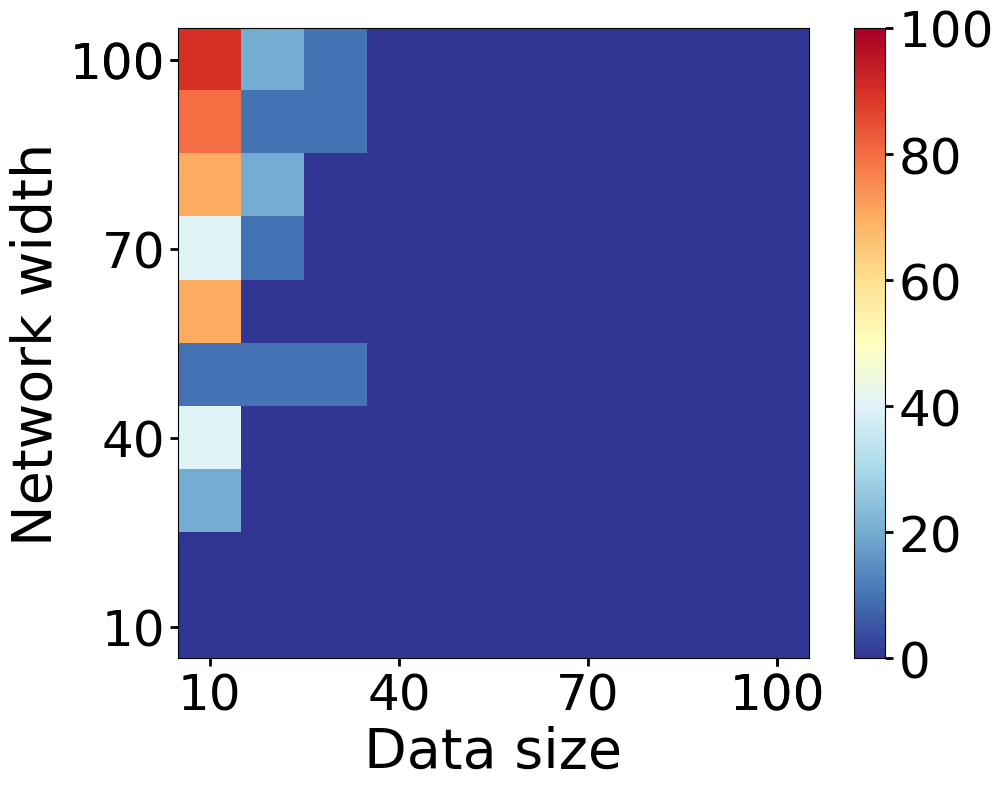

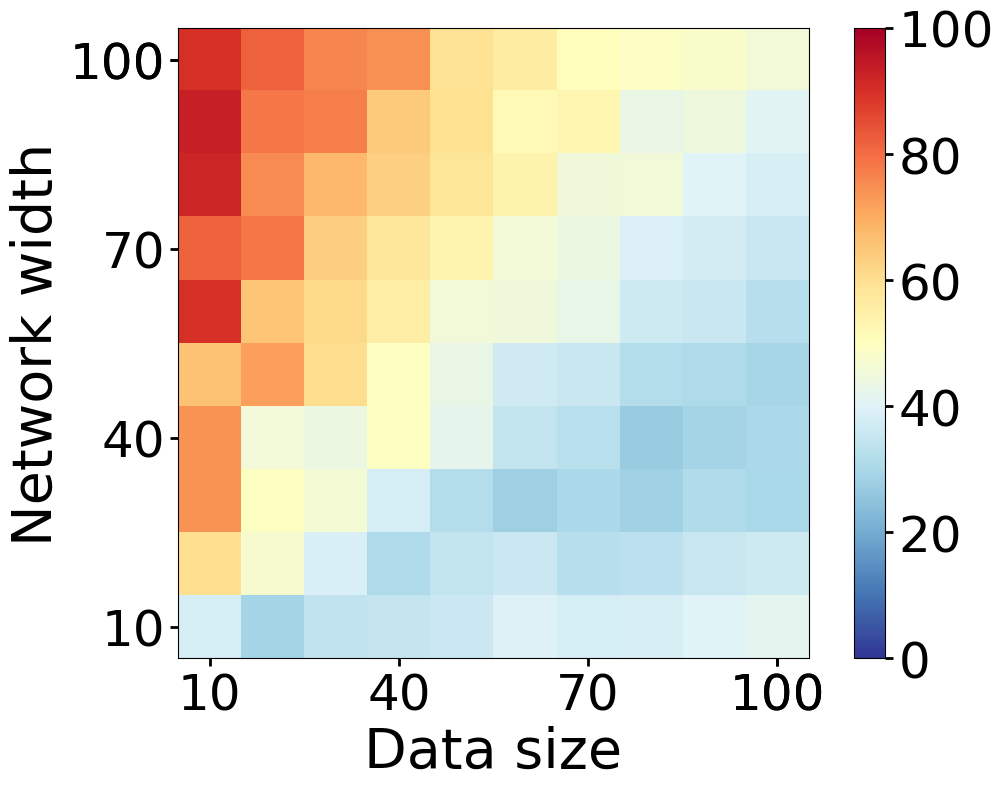

In [18]:
def plot_colormap(data, filename):
    colormap_arr = ['RdYlBu_r']
    step = 3

    for colormap in colormap_arr:
        timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

        fig = plt.figure(figsize=(10.7, 8), dpi=100)
        ax = fig.add_subplot(111)
        ax.tick_params(axis='both', which='major', labelsize=36)
        ax.tick_params(axis='both', which='minor', labelsize=36)
        ax.tick_params(length=6, width=2)

        plt.xlabel('Data size', size=40)
        plt.ylabel('Network width', size=40)
        plt.margins(x=0)

        plt.xticks(list(range(0, len(data_size_arr) , step)) + [len(data_size_arr) - 1],
                   [d for di, d in enumerate(data_size_arr) if di % step == 0] + [data_size_arr[-1]])
        plt.yticks(list(range(0, len(d1_arr), step)) + [len(d1_arr) - 1],
                   [d for di, d in enumerate(d1_arr) if di % step == 0] + [d1_arr[-1]])

        cp = plt.imshow(data, cmap=colormap, origin='lower', interpolation='nearest', vmin=0, vmax=100)
        cbar = fig.colorbar(cp, ticks=[0, 20, 40, 60, 80, 100])
#         cbar.ax.minorticks_on()
        cbar.ax.tick_params(length=6, width=2)
#         cbar.ax.tick_params(which='minor', length=3, width=1)

        cbar.ax.tick_params(labelsize=36)
        plt.tight_layout()

        plt.savefig(f'images/random_local_or_global/{timestamp}_d0_{D0}_{filename}_{colormap}.png')
        
plot_colormap(total_zero_loss, filename='global_percentage')
plot_colormap(total_A_rank, filename='full_rank_percentage')